In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing

# Dataset Load

In [2]:
df = pd.read_csv('project_dataset.csv')
# Dataset 내의 이상한 column 존재하여 삭제
df.drop('Unnamed: 0', axis=1, inplace=True)
df = df.rename(columns={"alchol":"alcohol"})

In [3]:
df['smoke'] = df['smoke'].apply(lambda x: 2 if x >= 10 else (1 if x >= 1 else 0))

In [4]:
male = [1899.5, 1000, 74.0, 51.5, 16.5, 17.0, 12.8, 1.9, 10.9, 267.4, 262.5, 24.4, 57.6, 486.3,
        1070.1, 3224.1, 2676.5, 298.4,10.0, 10.3, 401.1, 3.0, 7.1 ,2225.02 ,118.08 ,1.2 ,1.5 ,16.0 ,400.0 ,67.3]
female = [1583.8, 800 ,60.6 ,43.7 ,14.1 ,14.1 ,11.0 ,1.7,9.3, 226.4 ,226.2, 21.6 ,53.4 
          ,438.3 ,908.6 ,2660.0 ,2366.8, 259.8 ,8.4 ,8.5 ,433.0 ,3.4 ,6.2 ,1773.52 ,107.48 ,1.1 ,1.2 ,14.0,400.0 ,59.8]


#  Categorization


## 이상치 제거
trial_1의 파일에서 본 그래프 상으로는
- Energy: 6000부터 제거
- Water: 3500부터 제거
- Protein: 2000부터 제거
- Fat: 2000부터 제거
...

In [5]:
 # 이상치(Outlier) 제거
def remove_outlier(dataframe, columns):
    df = dataframe
    for col in columns:
        q1 = df[col].quantile(0.01) # 1분위수 (25%)
        q3 = df[col].quantile(0.98) # 3분위수 (75%)
        df = df[(df[col] <= q3) & (df[col] >= q1)]
        df = df.reset_index(drop=True)
    return df

In [6]:
df = remove_outlier(df, ['energy' , 'fat', 'water'])

In [7]:
df

,sex,age,alcohol,stress,smoke,walk,gym,waist,colesterol_m,colesterol_h,...,carotene,vitamin_a1,bitamin_b1,bitamin_b2,vitamin_b3,vitamin_b9,vitamin_c,time_w,time_wk,metabolic
0,2.0,30.0,3.0,3.0,0,8.0,1.0,78.8,44.0,64.0,...,2395.110618,188.242681,0.730783,1.374047,9.867333,211.560890,11.807869,7.0,7.0,0
1,1.0,27.0,6.0,2.0,1,4.0,2.0,106.9,145.0,43.0,...,692.459417,23.029893,1.713697,2.160933,20.852513,567.485260,67.648867,9.0,8.0,0
2,1.0,26.0,6.0,2.0,2,8.0,1.0,90.5,110.0,56.0,...,2294.220626,6.875033,0.718120,0.701055,7.291171,195.121656,32.651644,10.0,10.0,0
3,1.0,43.0,5.0,3.0,0,6.0,6.0,86.2,96.0,52.0,...,218.887453,123.465564,1.910816,2.258930,26.253090,353.502991,41.643127,9.0,9.0,0
4,2.0,31.0,2.0,3.0,0,1.0,1.0,67.2,54.0,53.0,...,3538.937032,200.327633,1.699282,2.079089,21.284737,353.108873,46.382259,8.0,9.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7186,2.0,23.0,4.0,4.0,0,8.0,2.0,73.5,121.0,67.0,...,2188.688568,30.101491,0.553855,0.520587,4.454575,93.098617,7.395356,10.0,9.0,0
7187,1.0,43.0,2.0,3.0,0,4.0,2.0,84.3,296.0,42.0,...,7778.359051,14.062256,1.057929,1.831747,14.732215,330.510562,38.946349,7.0,8.0,0
7188,2.0,38.0,2.0,1.0,0,7.0,1.0,83.2,51.0,53.0,...,3796.327639,31.655143,0.395779,1.149846,7.218674,139.117858,34.602894,5.0,7.0,0
7189,1.0,45.0,5.0,2.0,0,6.0,4.0,110.7,299.0,37.0,...,1472.979490,159.422485,0.881561,1.532354,14.065870,302.828285,21.532513,5.0,5.0,1


# Dataset을 Train Set과 Test Set으로 분리
- Column을 나눔: 생활습관 관련, 대사성 증후군 관련, 영양소 관련
- 대사성 증후군의 판단 기준이 되는 columns을 사용하여 대사성 증후군을 예측했기 때문에 meta_col은 모델링에 필요 없는 columns
- X, y로 나누고 train set과 test set으로 분리
- 필요하다면 test set을 test set과 valid set으로 분리 가능

In [8]:
# 생활습관에 관련된 columns
# 성별, 나이, 음주빈도, 평소 스트레스인지 정도, 하루평균 일반담배(궐련) 흡연량,
# 1주일간 걷기 일수, 1주일간 근력운동일수, 허리둘레, 중성지방, HDL 고밀도 지방
# 최종 수축기 혈압, 최종 이완기 혈압, 공복혈당, 주중 수면 시간, 주말 수면 시간
life_col = ['sex', 'age', 'alcohol', 'stress', 'smoke', 'walk', 'gym', 'time_w', 'time_wk']

In [9]:
# 대서성 증후군의 판단 기준이 되는 columns: 허리둘레, 중성지방, 고밀도 지방, 최종 수축기 혈압, 최종 이완기 혈압, 공복혈당
# 수축기 혈압 130mmHg 이상 또는 이완기 혈압 85mmHg 이상인 경우이므로 수축기 혈압과 이완기 혈압 모두 columns에 포함
meta_col = ['waist', 'colesterol_m', 'colesterol_h', 'contraction', 'relaxation', 'bloodsugar','metabolic']

In [10]:
# 영양소에 관련된 columns
# 에너지, 물, 단백질 등등
nutri_col = ['energy', 'water', 'protein', 'fat', 'sa_fat',
       'mono_unsa_fat', 'poly_unsa_fat', 'n3_fat', 'n6_fat',
       'colesterol_total', 'carbohydrate', 'dietary_fiber', 'sugar', 'calcium',
       'phosphorus', 'natrium', 'kalium', 'magnesium', 'iron', 'zinc',
       'vitamin_a', 'vitamin_D', 'vitamin_e', 'carotene', 'vitamin_a1',
       'bitamin_b1', 'bitamin_b2', 'vitamin_b3', 'vitamin_b9', 'vitamin_c']

In [11]:
maledf = df[df['sex'] == 1]
femaledf = df[df['sex']== 2]

In [12]:
for i in range(len(nutri_col)):
    column = nutri_col[i]
    standard = male[i]
    bins = [0]
    bins.append(standard*0.375)
    bins.append(standard*0.75)
    bins.append(standard*1.25)
    max_num = maledf[column].max()
    upper = max_num - standard * (1.2)
    bins.append(standard*1.1 + upper*(1/2))
    bins.append(max_num *2)
    maledf[column] = np.digitize(maledf[column], bins)

C:\Users\sangjin\AppData\Local\Temp\ipykernel_25800\447505286.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maledf[column] = np.digitize(maledf[column], bins)


In [13]:
maledf

,sex,age,alcohol,stress,smoke,walk,gym,waist,colesterol_m,colesterol_h,...,carotene,vitamin_a1,bitamin_b1,bitamin_b2,vitamin_b3,vitamin_b9,vitamin_c,time_w,time_wk,metabolic
1,1.0,27.0,6.0,2.0,1,4.0,2.0,106.9,145.0,43.0,...,1,1,4,4,4,4,3,9.0,8.0,0
2,1.0,26.0,6.0,2.0,2,8.0,1.0,90.5,110.0,56.0,...,3,1,2,2,2,2,2,10.0,10.0,0
3,1.0,43.0,5.0,3.0,0,6.0,6.0,86.2,96.0,52.0,...,1,3,4,4,4,3,2,9.0,9.0,0
5,1.0,34.0,4.0,2.0,0,8.0,1.0,97.9,320.0,36.0,...,3,2,2,3,2,3,3,8.0,8.0,1
8,1.0,44.0,5.0,2.0,0,5.0,1.0,78.7,252.0,69.0,...,2,1,4,3,3,2,1,9.0,9.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7181,1.0,35.0,2.0,3.0,0,5.0,1.0,68.4,82.0,47.0,...,4,3,2,3,2,3,2,8.0,8.0,0
7183,1.0,40.0,4.0,4.0,0,7.0,5.0,83.9,42.0,58.0,...,4,4,4,4,2,4,3,9.0,9.0,0
7185,1.0,47.0,1.0,2.0,0,5.0,1.0,84.1,216.0,36.0,...,2,1,2,2,2,2,1,6.0,6.0,1
7187,1.0,43.0,2.0,3.0,0,4.0,2.0,84.3,296.0,42.0,...,4,1,3,3,3,3,2,7.0,8.0,0


In [14]:
X1 = maledf.drop(columns=meta_col)
y1 = maledf['metabolic'] # target

In [15]:
for i in range(len(nutri_col)):
    column = nutri_col[i]
    standard = female[i]
    bins = [0]
    bins.append(standard*0.3)
    bins.append(standard*0.6)
    bins.append(standard*0.9)
    bins.append(standard*1.1)
    max_num = femaledf[column].max()
    upper = max_num - standard * (1.1)
    bins.append(standard*1.1 + upper*(1/3))
    bins.append(standard*1.1 + upper*(2/3))
    bins.append(max_num *2)
    femaledf[column] = np.digitize(femaledf[column], bins)

C:\Users\sangjin\AppData\Local\Temp\ipykernel_25800\2404046975.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  femaledf[column] = np.digitize(femaledf[column], bins)


In [16]:
X2 = femaledf.drop(columns=meta_col)
y2 = femaledf['metabolic'] # target

In [17]:
X = pd.concat([X1,X2])
y = pd.concat([y1,y2])

In [18]:
X = X.drop(columns = ['carotene', 'sa_fat', 'mono_unsa_fat','n6_fat',  'vitamin_b3', 'phosphorus',
                      'kalium' ]) # 상관관계가 높은 거는 다 뺌

In [19]:
X

,sex,age,alcohol,stress,smoke,walk,gym,energy,water,protein,...,vitamin_a,vitamin_D,vitamin_e,vitamin_a1,bitamin_b1,bitamin_b2,vitamin_b9,vitamin_c,time_w,time_wk
1,1.0,27.0,6.0,2.0,1,4.0,2.0,5,5,4,...,1,1,3,1,4,4,4,3,9.0,8.0
2,1.0,26.0,6.0,2.0,2,8.0,1.0,2,2,2,...,2,1,2,1,2,2,2,2,10.0,10.0
3,1.0,43.0,5.0,3.0,0,6.0,6.0,5,4,4,...,1,4,2,3,4,4,3,2,9.0,9.0
5,1.0,34.0,4.0,2.0,0,8.0,1.0,3,4,3,...,3,2,3,2,2,3,3,3,8.0,8.0
8,1.0,44.0,5.0,2.0,0,5.0,1.0,3,3,3,...,1,1,2,1,4,3,2,1,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7182,2.0,31.0,2.0,3.0,0,3.0,1.0,3,3,2,...,2,1,2,5,2,2,1,2,8.0,8.0
7184,2.0,23.0,2.0,3.0,0,3.0,1.0,3,2,2,...,1,1,2,1,2,5,1,3,9.0,9.0
7186,2.0,23.0,4.0,4.0,0,8.0,2.0,2,2,2,...,2,1,2,1,2,2,1,1,10.0,9.0
7188,2.0,38.0,2.0,1.0,0,7.0,1.0,3,2,3,...,3,1,2,1,2,4,2,2,5.0,7.0


In [20]:
# train_test_split에서 stratify는 분류(classification)를 다룰 때 매우 중요한 옵션값, stratify 값을 target으로 지정하면 각각의 class 비율(ratio)을 train / validation에 유지(한 쪽에 쏠려서 분배되는 것을 방지
# 만약 이 옵션을 지정하지 않고 분류(classification) 문제를 다루면, 성능의 차이가 많이 날 가능성 높음
# 현재 Dataset에서 대사성 증후군인 사람과 아닌 사람의 비율 = 1:4
# 이 비율 그대로 train, test 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# Feature Scaling
- 수업 시간에 배운 표준화(Standardization)과 정규화(Normalization)을 적용 가능
- Decision Tree는 규칙에 대해 학습하는 것이므로 성능의 차이 없음



# Modeling
1. 생활 습관과 관련된 columns를 통해 특정 사람이 대사성 증후군에 걸릴 건지 안 걸릴 건지 예측하는 Decision Tree를 생성
2. Tree의 max_depth를 설정하지 않으면 Overfitting 발생
 - max_depth 없이 해보면 정확도가 train 약 91, test 약 69
3. 현재 Model에 대한 Confusion Matrix에 대한 정리
 - 정확도(Accuracy)는 높음
 - 대사성 증후군이 아닌 사람을 대사성 증후군이 아니라고 예측 -> 좋은 성능
 - 실제 대사성 증후군인 사람을 대사성 증후군이라고 예측 -> 성능 안 좋음
 - 프로젝트 주제에는 실제 대사성 증후군인 사람을 대사성 증후군이라고 예측하는 것이 더 중요함
 - 즉, recall 값을 높여야 하기 때문에 Parameter 수정 필요

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

In [22]:
# Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [23]:
from sklearn.pipeline import make_pipeline, Pipeline

## Decision Tree

### Parameter 수정
DecisionTreeClassifier()의 parameters
1. criterion: “gini”, “entropy”, “log_loss”
 - default: ”gini”
2. splitter: “best”, “random”
 - defalut: ”best”
3. max_depth: integer
 - 트리의 최대 깊이
 - defalut: None → 완벽하게 클래스 값이 결정될 때 까지 분할
 - 깊이가 깊어지면 과적합될 수 있으므로 적절히 제어 필요
4. min_samples_split: integer or float
 - 노드를 분할하기 위한 최소한의 샘플 데이터수
 - default: 2 → 작게 설정할 수록 분할 노드가 많아져 과적합 가능성 증가
5. min_samples_leaf: integer or float
 - 리프노드가 되기 위해 필요한 최소한의 샘플 데이터수
 - 불균형 데이터의 경우 특정 클래스의 데이터가 극도로 작을 수 있으므로 작게 설정 필요
 - default: 2
6. max_features: “auto”, “sqrt”, “log2”
 - 최적의 분할을 위해 고려할 최대 feature 개수
 - default: None → 데이터 세트의 모든 피처를 사용
 - int형으로 지정 →피처 갯수 / float형으로 지정 →비중
 - sqrt 또는 auto : 전체 피처 중 √(피처개수) 만큼 선정
 - log2 : 전체 피처 중 log2(전체 피처 개수) 만큼 선정
7. max_leaf_nodes: integer
 - 리프노드의 최대 개수
 - defalut: None
8. min_impurity_decrease: float
 - default: 0.0
9. min_weight_fraction_leaf: float,
 - default: 0.0

3, 4, 5, 6, 7번 Parameter가 중요하므로 이 위주로 수정

출처: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

학습 데이터 점수:  62.03
평가 데이터 점수:  60.18


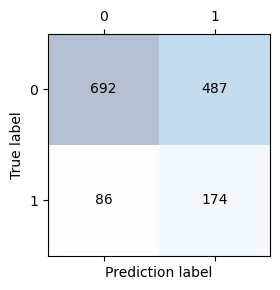

정확도(accuracy):  0.60
정밀도(precision):  0.26
재현율(recall):  0.67
F1 score:  0.38


In [38]:
class_weight = {1: 0.8,
                0: 0.2}

dt = DecisionTreeClassifier(criterion="gini", max_depth=6,  max_features="auto", min_samples_leaf=2, min_samples_split=6, class_weight=class_weight)
dt.fit(X_train, y_train)
predict = dt.predict(X_test)

train_score = dt.score(X_train, y_train)
test_score = dt.score(X_test, y_test)
print("학습 데이터 점수: {: .2f}".format(train_score * 100))
print("평가 데이터 점수: {: .2f}".format(test_score * 100))

# Confusion Matrix
confmat = confusion_matrix(y_true=y_test, y_pred=predict)

fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('Prediction label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

accuracy = accuracy_score(y_test, predict)
precision = precision_score(y_test, predict)
recall = recall_score(y_test, predict)
print("정확도(accuracy): {: .2f}".format(accuracy))
print("정밀도(precision): {: .2f}".format(precision))
print("재현율(recall): {: .2f}".format(recall))

f1 = f1_score(y_test, predict)
print("F1 score: {: .2f}".format(f1))

### Feature Importance
-  Feature의 중요성을 바탕으로 Feature Selection 가능

In [39]:
for name, value in zip(X_train.columns, dt.feature_importances_):
    print('{0}: {1:.3f}'.format(name, value))

sex: 0.121
age: 0.252
alcohol: 0.023
stress: 0.030
smoke: 0.000
walk: 0.049
gym: 0.000
energy: 0.000
water: 0.000
protein: 0.011
fat: 0.022
poly_unsa_fat: 0.000
n3_fat: 0.000
colesterol_total: 0.028
carbohydrate: 0.005
dietary_fiber: 0.014
sugar: 0.131
calcium: 0.022
natrium: 0.046
magnesium: 0.024
iron: 0.005
zinc: 0.000
vitamin_a: 0.016
vitamin_D: 0.005
vitamin_e: 0.000
vitamin_a1: 0.104
bitamin_b1: 0.000
bitamin_b2: 0.000
vitamin_b9: 0.024
vitamin_c: 0.028
time_w: 0.008
time_wk: 0.030


In [30]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=1,penalty='l2',class_weight=class_weight)
log_reg.fit(X_train,y_train)

log_acc=accuracy_score(y_test,log_reg.predict(X_test))
predict = log_reg.predict(X_test)

print("Train Set Accuracy:"+str(accuracy_score(y_train,log_reg.predict(X_train))*100))
print("Test Set Accuracy:"+str(accuracy_score(y_test,log_reg.predict(X_test))*100))

Train Set Accuracy:68.115438108484
Test Set Accuracy:69.77067407922168


C:\Users\sangjin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


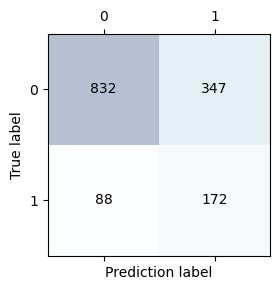

정확도(accuracy):  0.70
정밀도(precision):  0.33
재현율(recall):  0.66
F1 score:  0.44


In [31]:
# Confusion Matrix
confmat = confusion_matrix(y_true=y_test, y_pred=predict)

fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('Prediction label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

accuracy = accuracy_score(y_test, predict)
precision = precision_score(y_test, predict)
recall = recall_score(y_test, predict)
print("정확도(accuracy): {: .2f}".format(accuracy))
print("정밀도(precision): {: .2f}".format(precision))
print("재현율(recall): {: .2f}".format(recall))

f1 = f1_score(y_test, predict)
print("F1 score: {: .2f}".format(f1))

## SVC
- SVM은 입력 데이터가 정규화 되어야 좋은 성능을 보임
- 주로 모든 특성 값을 [0, 1] 사이의 범위로 만듦
- Standardization 또는 MinMaxScaler 사용


In [32]:
# SVC
from sklearn.svm import SVC

In [33]:
svc = SVC(kernel='linear',class_weight=class_weight)
svc.fit(X_train, y_train)
predict = svc.predict(X_test)

train_score = svc.score(X_train, y_train)
test_score = svc.score(X_test, y_test)
print("학습 데이터 점수: {: .2f}".format(train_score * 100))
print("평가 데이터 점수: {: .2f}".format(test_score * 100))

학습 데이터 점수:  68.79
평가 데이터 점수:  70.54


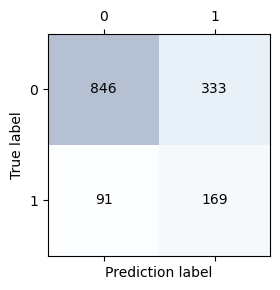

In [34]:
# Confusion Matrix
confmat = confusion_matrix(y_true=y_test, y_pred=predict)

fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('Prediction label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [35]:
accuracy = accuracy_score(y_test, predict)
precision = precision_score(y_test, predict)
recall = recall_score(y_test, predict)
print("정확도(accuracy): {: .2f}".format(accuracy))
print("정밀도(precision): {: .2f}".format(precision))
print("재현율(recall): {: .2f}".format(recall))

f1 = f1_score(y_test, predict)
print("F1 score: {: .2f}".format(f1))

정확도(accuracy):  0.71
정밀도(precision):  0.34
재현율(recall):  0.65
F1 score:  0.44
